# 0. About

This notebook is to test the PCA with Gaussian Process Regression.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_regression(
    n_samples=400, n_features=15, n_informative=3, 
    effective_rank=1, tail_strength=0.2, 
    n_targets=1, random_state=42
)

# 1. Check Scree Plot and Apply PCA

In [3]:
# scaling data
scale_obj = StandardScaler()
scale_obj.fit(X)
X_scaled = scale_obj.transform(X)

# PCA on all features
PCA_obj_scaled = PCA(random_state=42)
PCA_obj_scaled.fit(X_scaled)
PCA_obj_original = PCA(random_state=42)
PCA_obj_original.fit(X)

# compute cumulative explained variance ratio
cu_evr_scaled = np.zeros_like(PCA_obj_scaled.explained_variance_ratio_)
cu_evr_original = np.zeros_like(cu_evr_scaled)
for i in range(PCA_obj_scaled.n_components_):
    cu_evr_scaled[i] = PCA_obj_scaled.explained_variance_ratio_[:i+1].sum()
    cu_evr_original[i] = PCA_obj_original.explained_variance_ratio_[:i+1].sum()

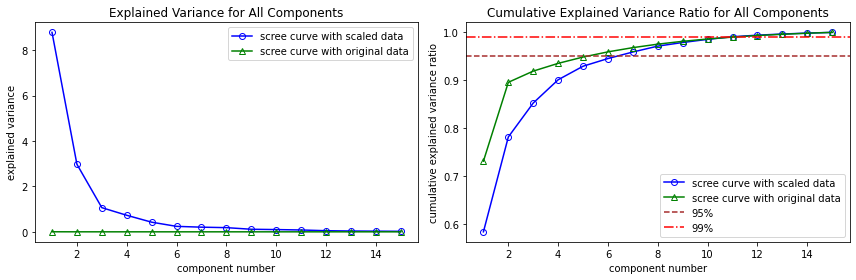

In [4]:
# visualize explained variance and variance ratio
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(
    np.arange(1, PCA_obj_scaled.n_components_+1, 1), 
    PCA_obj_scaled.explained_variance_, 'b-o', 
    markeredgecolor='blue', markerfacecolor='none', 
    label='scree curve with scaled data'
)
axes[0].plot(
    np.arange(1, PCA_obj_original.n_components_+1, 1), 
    PCA_obj_original.explained_variance_, 'g-^', 
    markeredgecolor='green', markerfacecolor='none', 
    label='scree curve with original data'
)
axes[0].set_xlabel('component number')
axes[0].set_ylabel('explained variance')
axes[0].set_title('Explained Variance for All Components')
axes[0].legend()

axes[1].plot(
    np.arange(1, PCA_obj_scaled.n_components_+1, 1), cu_evr_scaled, 'b-o', 
    markeredgecolor='blue', markerfacecolor='none', 
    label='scree curve with scaled data'
)
axes[1].plot(
    np.arange(1, PCA_obj_original.n_components_+1, 1), cu_evr_original, 'g-^', 
    markeredgecolor='green', markerfacecolor='none', 
    label='scree curve with original data'
)
axes[1].axhline(y=0.95, color='brown', ls='--', label='95%')
axes[1].axhline(y=0.99, color='red', ls='-.', label='99%')
axes[1].set_xlabel('component number')
axes[1].set_ylabel('cumulative explained variance ratio')
axes[1].set_title('Cumulative Explained Variance Ratio for All Components')
axes[1].legend()

plt.tight_layout()

In [5]:
PC_num_scaled = cu_evr_scaled[cu_evr_scaled<=0.95].shape[0]
PC_num_original = cu_evr_original[cu_evr_original<=0.95].shape[0]
print('For scaled data, the components number we need is {:}'.format(PC_num_scaled))
print('For original data, the components number we need is {:}'.format(PC_num_original))

# apply PCA transform
PCA_obj_scaled = PCA(random_state=42, n_components=PC_num_scaled)
PCA_obj_scaled.fit(X_scaled)
PCA_obj_original = PCA(random_state=42, n_components=PC_num_original)
PCA_obj_original.fit(X);

For scaled data, the components number we need is 6
For original data, the components number we need is 5


# 2. Guassian Process Regression

In [6]:
# for scaled data
kernel_scaled = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((PCA_obj_scaled.n_components_, )))
gpr_obj_scaled = GaussianProcessRegressor(
    kernel=kernel_scaled, alpha=1e-6, n_restarts_optimizer=15, random_state=42
)
gpr_scores_scaled = cross_validate(gpr_obj_scaled, PCA_obj_scaled.transform(X_scaled), y, cv=5)

print('For scaled data: ')
print(gpr_scores_scaled)

For scaled data: 
{'fit_time': array([9.43984842, 7.59335446, 8.79184723, 7.83338237, 9.64134669]), 'score_time': array([0.00099444, 0.00099707, 0.00099754, 0.00099754, 0.00099707]), 'test_score': array([0.81329514, 0.82781839, 0.86357969, 0.66201628, 0.77307116])}


In [7]:
# for original data
kernel_original = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((PCA_obj_original.n_components_, )))
gpr_obj_original = GaussianProcessRegressor(
    kernel=kernel_original, alpha=1e-6, n_restarts_optimizer=15, random_state=42
)
gpr_scores_original = cross_validate(gpr_obj_original, PCA_obj_original.transform(X), y, cv=5)

print('For original data: ')
print(gpr_scores_original)

For original data: 
{'fit_time': array([14.66600847, 14.898     , 12.45368433, 12.65909839, 13.51803088]), 'score_time': array([0.00099754, 0.00199604, 0.00099683, 0.00199461, 0.00099659]), 'test_score': array([0.85585513, 0.8724881 , 0.83850984, 0.66853658, 0.828757  ])}


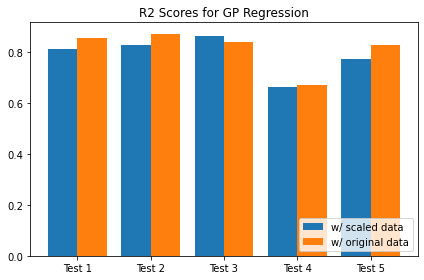

In [8]:
test_strings = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
test_axis = np.arange(len(test_strings))
plt.bar(test_axis-0.2, gpr_scores_scaled['test_score'], 0.4, label='w/ scaled data')
plt.bar(test_axis+0.2, gpr_scores_original['test_score'], 0.4, label='w/ original data')
plt.xticks(test_axis, test_strings)
plt.title('R2 Scores for GP Regression')
plt.legend(loc='lower right')
plt.tight_layout()

It looks like the performance are similar.
Now we can split training and testing datasets to see how it goes actually.

In [9]:
[X_train_scaled, 
 X_test_scaled, 
 y_train_scaled, 
 y_test_scaled] = train_test_split(X_scaled, y, test_size=0.20, random_state=23)

[X_train_original, 
 X_test_original, 
 y_train_original, 
 y_test_original] = train_test_split(X, y, test_size=0.20, random_state=32)

In [10]:
# training models with training dataset
kernel_scaled = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((PCA_obj_scaled.n_components_, )))
gpr_obj_scaled = GaussianProcessRegressor(
    kernel=kernel_scaled, alpha=1e-6, n_restarts_optimizer=15, random_state=42
)
gpr_obj_scaled.fit(PCA_obj_scaled.transform(X_train_scaled), y_train_scaled)

kernel_original = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((PCA_obj_original.n_components_, )))
gpr_obj_original = GaussianProcessRegressor(
    kernel=kernel_original, alpha=1e-6, n_restarts_optimizer=15, random_state=42
)
gpr_obj_original.fit(PCA_obj_original.transform(X_train_original), y_train_original)

GaussianProcessRegressor(alpha=1e-06,
                         kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1]),
                         n_restarts_optimizer=15, random_state=42)

In [11]:
# making regression over the test data
y_pred_scaled, std_pred_scaled = gpr_obj_scaled.predict(PCA_obj_scaled.transform(X_test_scaled), return_std=True)
y_pred_original, std_pred_original = gpr_obj_original.predict(PCA_obj_original.transform(X_test_original), return_std=True)

In [12]:
def sort_it_out(X_test, feature_ind, y_pred, std_pred):
    one_col_arr = X_test[:, feature_ind].copy()
    y_pred_sorted = y_pred[one_col_arr.argsort()]
    std_pred_sorted = std_pred[one_col_arr.argsort()]
    one_col_arr.sort()
    lb_pred_sorted = y_pred_sorted.flatten() - 2*std_pred_sorted
    ub_pred_sorted = y_pred_sorted.flatten() + 2*std_pred_sorted
    
    return [one_col_arr, y_pred_sorted, std_pred_sorted, lb_pred_sorted, ub_pred_sorted]

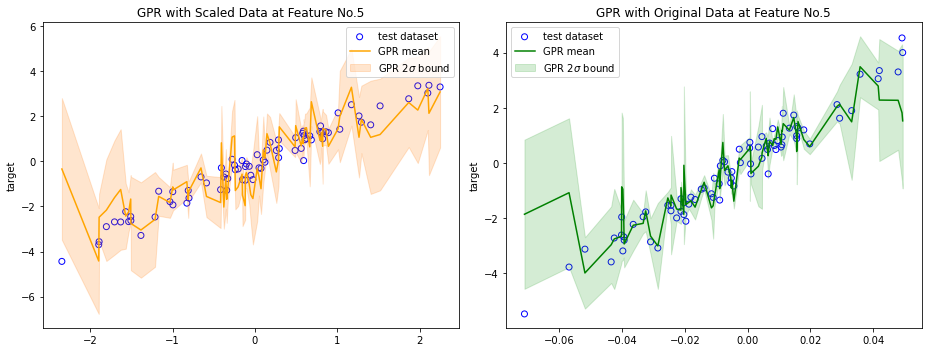

In [13]:
# choose one feature to visualize the regression prediction
feature_ind = 4

[one_col_arr_scaled, 
 y_pred_sorted_scaled, 
 std_pred_sorted_scaled, 
 lb_pred_sorted_scaled, 
 ub_pred_sorted_scaled] = sort_it_out(
    X_test_scaled, feature_ind, y_pred_scaled, std_pred_scaled
)

[one_col_arr_original, 
 y_pred_sorted_original, 
 std_pred_sorted_original, 
 lb_pred_sorted_original, 
 ub_pred_sorted_original] = sort_it_out(
    X_test_original, feature_ind, y_pred_original, std_pred_original
)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].scatter(X_test_scaled[:, feature_ind], y_test_scaled, fc='none', ec='blue', label='test dataset')
axes[0].plot(one_col_arr_scaled, y_pred_sorted_scaled, 'orange', label='GPR mean')
axes[0].fill_between(
    one_col_arr_scaled.ravel(),
    lb_pred_sorted_scaled,
    ub_pred_sorted_scaled,
    color="tab:orange",
    alpha=0.2,
    label=r"GPR 2$\sigma$ bound",
)
axes[0].set_ylabel('target')
axes[0].set_title('GPR with Scaled Data at Feature No.{:}'.format(feature_ind+1))
axes[0].legend()

axes[1].scatter(X_test_original[:, feature_ind], y_test_original, fc='none', ec='blue', label='test dataset')
axes[1].plot(one_col_arr_original, y_pred_sorted_original, 'green', label='GPR mean')
axes[1].fill_between(
    one_col_arr_original.ravel(),
    lb_pred_sorted_original,
    ub_pred_sorted_original,
    color="tab:green",
    alpha=0.2,
    label=r"GPR 2$\sigma$ bound",
)
axes[1].set_ylabel('target')
axes[1].set_title('GPR with Original Data at Feature No.{:}'.format(feature_ind+1))
axes[1].legend()

plt.tight_layout()